## Running Inference with our Seq2Seq model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import torch
import torch.nn.functional as F
import h5py
import numpy as np
import glob
from common.quaternion import quat_mul
from common.data_utils import read_h5
from common.skeleton import Skeleton
from seq2seq.training_utils import get_encoder, get_attn_decoder

### Loading in some data to test with

Let's start by loading in data.

We trained our model using "normOrientation" and "normAcceleration" from the T8 (sternum), both forearms, and both lower legs as input, so we'll read in that data. We'll also read in some data for "normOrientation" on the entire body because this is the output of our model. Finally, we'll read in data for the orientation of the pelvis. This is important because we want to rotate the "normOrientation" data back into it's original reference frame.

In [2]:
group = ["T8", "RightForeArm", "RightLowerLeg", "LeftForeArm", "LeftLowerLeg"]

filepaths = glob.glob("../data/*.h5")
requests = {"normOrientation" : ["all"], "orientation" : ["Pelvis"]}
dataset = read_h5(filepaths, requests)

filename = filepaths[0].split("/")[-1]
fullBodyOrientations = torch.Tensor(dataset[filename]["normOrientation"]).double()
root = torch.Tensor(dataset[filename]['orientation']).double()

requests = {"normOrientation" : group, "normAcceleration" : group}
dataset = read_h5(filepaths, requests)
orientationInputs = torch.Tensor(dataset[filename]["normOrientation"]).double()
accelerationInputs = torch.Tensor(dataset[filename]["normAcceleration"]).double()

with h5py.File("../data/set-2/normalization.h5", "r") as f:
    mean, std_dev = torch.Tensor(f["mean"]), torch.Tensor(f["std_dev"])

### Loading in the Seq2Seq Model

We can now load in our Seq2Seq models (encoder and decoder).

The models must have the same arguments used during training so that errors don't pop up.

In [3]:
encoder_feature_size = len(group)*4 + len(group)*3
decoder_feature_size = 92
hidden_size = 512
attention = "dot"
bidirectional = True

seq_length = 30
downsample = 6
in_out_ratio = 5


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = get_encoder(encoder_feature_size,
                      device,
                      hidden_size=hidden_size,
                      bidirectional=bidirectional)

decoder = get_attn_decoder(decoder_feature_size,
                           attention,
                           device,
                           hidden_size=hidden_size,
                           bidirectional_encoder=bidirectional)

    
decoder.batch_size = 1
decoder.attention.batch_size = 1

PATH = "/home/jackg7/VT-Natural-Motion-Processing/models/set-2/model.pt"

checkpoint = torch.load(PATH, map_location=device)

encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

encoder.eval()
decoder.eval()
models = (encoder, decoder)

### Defining the inference function

Our inference function needs to take in a batch of input data, pass it through both the encoder and decoder, and then return the output.

Note that this function is very similar to the *loss_batch* function defined in *src/seq2seq/training_utils.py*. Here it returns the outputs instead of the loss for training/validation purposes.

In [4]:
def inference(data, models, device, use_attention=False, norm_quaternions=False):
    encoder, decoder = models
    input_batch, target_batch = data

    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    seq_length = target_batch.shape[1]

    input = input_batch.permute(1, 0, 2)
    encoder_outputs, encoder_hidden = encoder(input)

    decoder_hidden = encoder_hidden
    decoder_input = torch.ones_like(target_batch[:, 0, :]).unsqueeze(0)
    
    outputs = torch.zeros_like(target_batch)

    for t in range(seq_length):

        if use_attention:
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
        else:
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            
        target = target_batch[:, t, :].unsqueeze(0).double()
            
        output = decoder_output

        if norm_quaternions:
            original_shape = output.shape

            output = output.view(-1,4)
            output = F.normalize(output, p=2, dim=1).view(original_shape)

        outputs[:, t, :] = output
        
        decoder_input = output.detach()

    return outputs

### Sampling some data and running it through the inference function

We can now sample some data and use our model to perform inference.

We only trained the model to predict a single posture and did not use much training data as this is just a tutorial.

Note we used normOrientations as output, so we have to put the orientation back into the original frame using the root's (pelvis) orientation.

In [5]:
i = 15330

inp = torch.cat((orientationInputs[i:i+seq_length:downsample, :], accelerationInputs[i:i+seq_length:downsample, :]), dim=1)
inp = inp.sub(mean).div(std_dev).double()

out = fullBodyOrientations[i:i+seq_length:downsample, :].double()
out = out[-1,:].unsqueeze(0) # trained our model to predict only a single pose

data = (inp.unsqueeze(0), out.unsqueeze(0))
      
output = inference(data, models, device, use_attention=True, norm_quaternions=True)

full_body = fullBodyOrientations[i:i+seq_length:downsample,:].clone()
full_body = full_body[-1, :].unsqueeze(0)

seq2seq_body = output.clone().squeeze(0)

root_motion = root[i:i+seq_length:downsample, :].clone()
root_motion = root_motion[-1, :].unsqueeze(0)

root_motion = root_motion.unsqueeze(1).repeat(1, full_body.shape[1]//4, 1)

full_body = quat_mul(root_motion, full_body.view(-1, full_body.shape[1]//4, 4)).view(full_body.shape)
seq2seq_body = quat_mul(root_motion, seq2seq_body.view(-1, seq2seq_body.shape[1]//4, 4)).view(seq2seq_body.shape)

Now that we have the ground truth posture and our seq2seq output, we can compare the motion using the Skeleton. 

The output won't look that great because we only used a single participant and a single epoch to train the model.

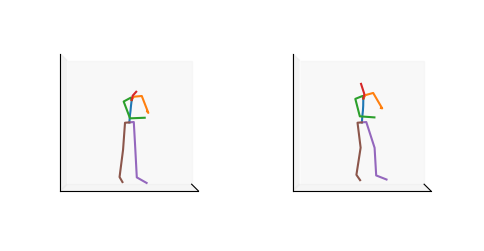

In [6]:
skeleton = Skeleton()
bodies = torch.cat((full_body, seq2seq_body), dim=0).float()
skeleton.compare_motion(bodies, azim=0, elev=0)